# Demand forecasting in retail industry

In this case study we are going to focus on 3 major markets: Germany, Austria and France, where managers want to better understand what is driving demand in their retail stores.

There are several topics that are going to be explored in this demo:
*  reliable sales forecasts
* effects of price/non-price promotions on sales
* effects of media advertising or in-store events on sales
* pricing strategy to maximize margin

## Input data

For this case study we are going to use two datasets:
1. **sales.txt** - transactional data on hisotrical retail sales containing weekly sales data per article per country:
    * country : country name
    * article : article unique identifier
    * sales : total number of units sold in respective week
    * regular_price : recommended retail price for article
    * current_price : current selling price (weighted average over the week)
    * ratio : price ratio as current_price/regular_price, helps determine discount rate as 1-price_ratio
    * retailweek : start date of retail week
    * promo1 : indicator of media advertising (1/0)
    * promo2 : indicator for store events (1/0)
    
    
    
2. **articles.txt** - attributes of the sold articles:
    * article : article unique identifier
    * productgroup : product group the article belongs to
    * category : product category the article belongs to
    * cost : selling costs of the article (assumed to be fixed over time)

## Implementation steps

1. Prepare and analyze data
2. Identify what is driving sales and what type of promotion has a stronger impact no sales
3. Forecast of sold units for the following month
4. Reliability tests for the methods developed above

# 1. Prepare and analyze data

In the first phase of this case study we are going to import, clean, and wrangle sales data to ensure data quality and suitability for analysis.

### Import data

In [1]:
# import basic Python libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import machine learning packages
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# import necessary seasonality decomposition and ARIMA modeling packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/cloudera/parcels/Anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import transactional sales data of articles into a pandas dataframe
sales_data = pd.read_csv("/var/lib/hadoop-hdfs/CristinaG/Datasets/sales.txt", sep = ";", parse_dates=['retailweek'])

# import attribute data of sold articles
attribute_data = pd.read_csv("/var/lib/hadoop-hdfs/CristinaG/Datasets/articles.txt", sep = ";")

### Inspect data

Verify the data quality from a high-level perspective.

In [3]:
# check sample of sales data
sales_data.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0


In [4]:
# display row count and column count for sales data
sales_data.shape

(81426, 9)

In [5]:
# check for any NaN values in sales transactional data. False means there are no NaN's in the dataset.
sales_data.isnull().values.any()

False

In [6]:
sales_data.describe()

,sales,regular_price,current_price,ratio,promo1,promo2
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000


In [7]:
# check sample of attribute data
attribute_data.head()

,article,category,productgroup,cost
0,OC6355,TRAINING,SHOES,13.29
1,AP5568,TRAINING,SHORTS,2.29
2,CB8861,GOLF,HARDWARE ACCESSORIES,1.70
3,LI3529,RUNNING,SHOES,9.00
4,GG8661,RELAX CASUAL,SHOES,9.60


In [8]:
# display row count and column count for attribute data
attribute_data.shape

(476, 4)

In [9]:
# check for any NaN values in sales attribute data. False means there are no NaN's in the dataset.
attribute_data.isnull().values.any()

False

In [10]:
attribute_data.describe()

,cost
count,476.00000
mean,5.17792
std,3.36282
min,0.40000
25%,2.60000
50%,4.25000
75%,7.90000
max,19.80000


From a high level perspective, the data looks okay. There aren't any NaN's in either dataset and the size of the dataframes makes sense based on the size of the raw data in the text files. The descriptive statistics on the data looks great as well.


Use pandas merge function to combine the transactional sales data with the sales attribute data like a SQL join. Use an inner join since I want to add cost data (if there is any) for the given transactional data. If there isn't any cost data, then I will not use the transactional sales data. I'll try a left join first to see if there are any cases where there is transactional data but not cost data for a given article. If there aren't many cases like this, then I will go ahead with the inner join.

In [11]:
data_leftJoined = pd.merge(sales_data, attribute_data, how = 'left', on = 'article')
data_leftJoined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2


In [12]:
data_leftJoined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81303.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060,5.002254
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953,3.352216
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.400000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000,4.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Investigate why there are less cost data points (count) than the other columns of data - likely due to there not being cost data for an article that had transactional sales data.


In [13]:
data_leftJoined[data_leftJoined.isnull().values].shape

(369, 12)

In [14]:
data_leftJoined.fillna(0, inplace = True)
data_leftJoined[data_leftJoined.isnull().values]

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost


In [15]:
data_leftJoined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000,81426.000000
mean,57.048375,52.620695,28.356811,0.544464,0.065041,0.005060,4.994698
std,88.506045,35.549601,22.704746,0.192692,0.246599,0.070953,3.355312
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.450000,20.950000,0.523526,0.000000,0.000000,3.950000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Even though I can fix the NaN values in the left join, I am going to go forward with the inner join so for all of the data I have both transactional sales and cost data. I want to avoid filling in NaN's with artificial 0's (or some other arbitrary value). Perform inner join of sales and attribute data.

In [16]:
data_joined = pd.merge(sales_data, attribute_data, how = 'inner', on = 'article')
data_joined.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
0,Germany,AA1821,62,31.95,25.95,0.812207,2014-12-28,1,0,RUNNING,T-SHIRTS,3.2
1,Germany,AA1821,29,31.95,22.95,0.718310,2015-01-04,0,0,RUNNING,T-SHIRTS,3.2
2,Germany,AA1821,58,31.95,28.95,0.906103,2015-01-11,0,0,RUNNING,T-SHIRTS,3.2
3,Germany,AA1821,49,31.95,29.95,0.937402,2015-01-18,0,0,RUNNING,T-SHIRTS,3.2
4,Germany,AA1821,883,31.95,24.95,0.780908,2015-01-25,0,0,RUNNING,T-SHIRTS,3.2


In [17]:
data_joined.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,cost
count,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000,81303.000000
mean,57.107868,52.661044,28.377229,0.544421,0.065041,0.005067,5.002254
std,88.552281,35.561332,22.714819,0.192656,0.246599,0.071006,3.352216
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.400000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,2.400000
50%,26.000000,41.950000,21.950000,0.523526,0.000000,0.000000,4.000000
75%,65.000000,79.950000,37.950000,0.697322,0.000000,0.000000,7.700000
max,898.000000,197.950000,197.950000,1.000000,1.000000,1.000000,19.800000


Verify there are no NaN values. False means there are no NaN's in the dataset.


In [18]:
data_joined.isnull().values.any()

False

There are no NaN values. Joined data looks good to move on to exploratory data analysis through plotting. It will be very useful to visualize the different categories of sales data.


### Plot data

In [11]:
# Plot the total number of units sold in a week
plt.figure()
data_joined.plot(x = 'retailweek', y = 'sales')
plt.show()

NameError: name 'data_joined' is not defined

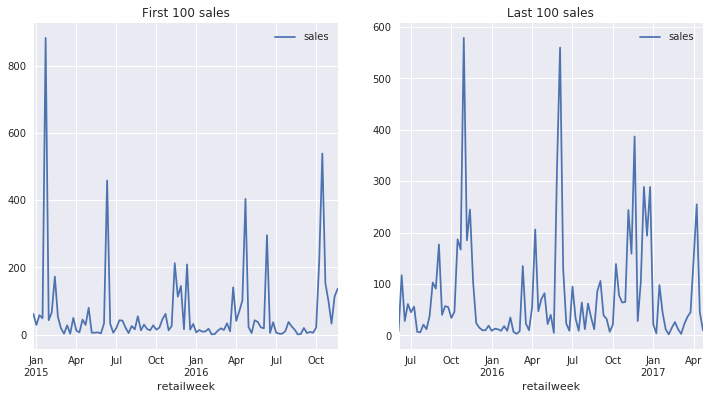

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
data_joined[0:100].plot(ax = axes[0], x = 'retailweek', y = 'sales')
axes[0].set_title('First 100 sales')

data_joined[-100:-1].plot(ax=axes[1], x = 'retailweek', y = 'sales')
axes[1].set_title('Last 100 sales')
plt.show()

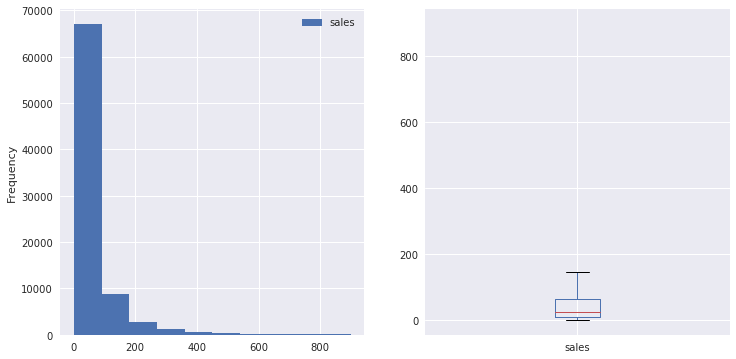

In [21]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
data_joined.plot(ax = axes[0], y = 'sales', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'sales', kind = 'box')
plt.show()

Sales data looks as expected; there are a lot of outliers likely at high sale times (like Christmas / winter holiday and summer before school starts). The sales data is pretty cyclical in addition to being heavily skewed with the vast majority of weeks with sales of less than 100 items for each item type.

Examine price data now.

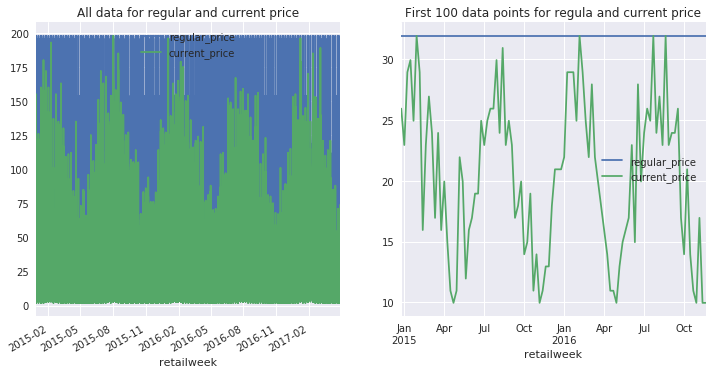

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = ['regular_price', 'current_price'])
axes[0].set_title('All data for regular and current price')
data_joined[0:100].plot(ax = axes[1], x = 'retailweek', y = ['regular_price', 'current_price'])
axes[1].set_title('First 100 data points for regula and current price')
plt.show()

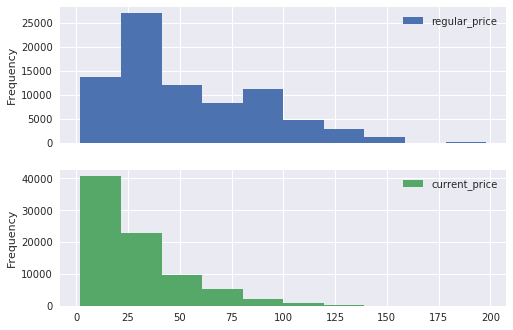

In [23]:
plt.figure()
data_joined.plot(y = ['regular_price', 'current_price'], kind = 'hist', subplots = True)
plt.show()

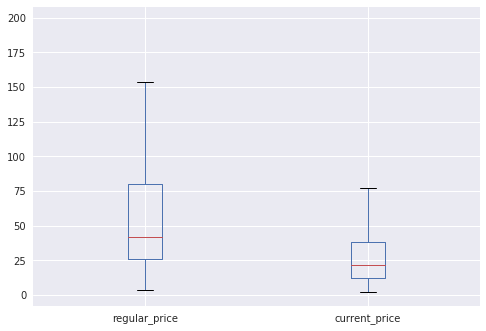

In [24]:
plt.figure()
data_joined.plot(y = ['regular_price', 'current_price'], kind = 'box')
plt.show()

Pricing data (regular price and current price) both look as expected; the regular price is higher than the current price (indicating that discounts, like promo1 and/or promo2, reduce the price). Both price datasets are skewed but the regular price looks like it could be closer to a normal distribution. The majority of items that are sold are priced under 75 euro.

Look into the ratio data (ratio = current_price / regular_price).

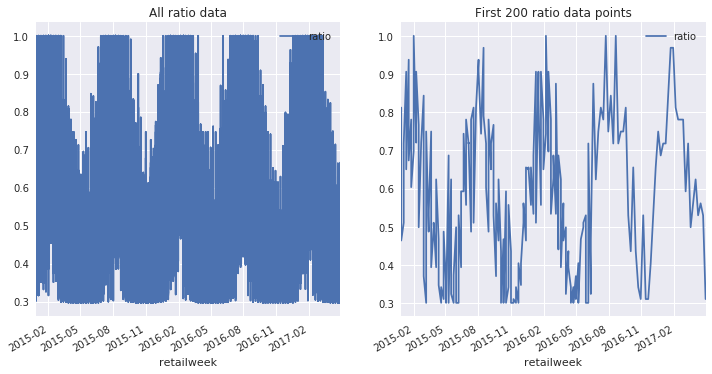

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = 'ratio')
axes[0].set_title('All ratio data')
data_joined[0:200].plot(ax = axes[1], x = 'retailweek', y = 'ratio')
axes[1].set_title('First 200 ratio data points')
plt.show()

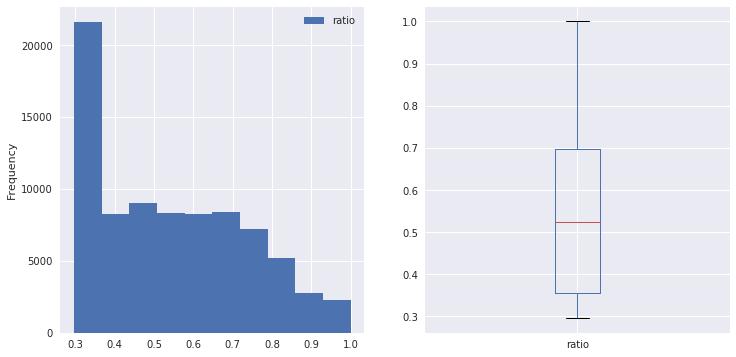

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], y = 'ratio', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'ratio', kind = 'box')
plt.show()

Ratio data is similarly skewed like the sales and pricing data - the cyclical nature of pricing items is very apparent in the data when zooming in on a smaller sample of the ratio data.

Examine the promo data (1 and 2) next.

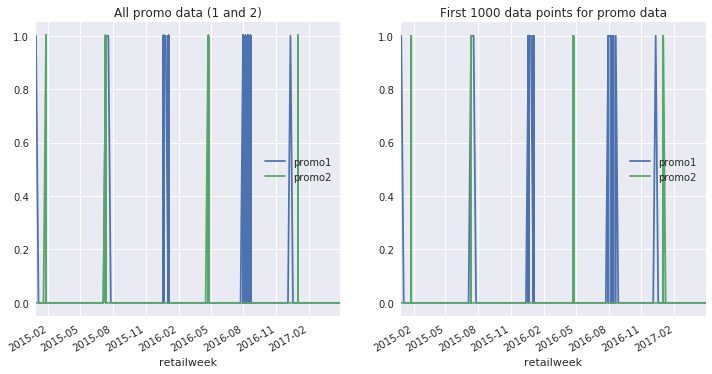

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = ['promo1', 'promo2'])
axes[0].set_title('All promo data (1 and 2)')
data_joined[0:1000].plot(ax = axes[1], x = 'retailweek', y = ['promo1', 'promo2'])
axes[1].set_title('First 1000 data points for promo data')
plt.show()

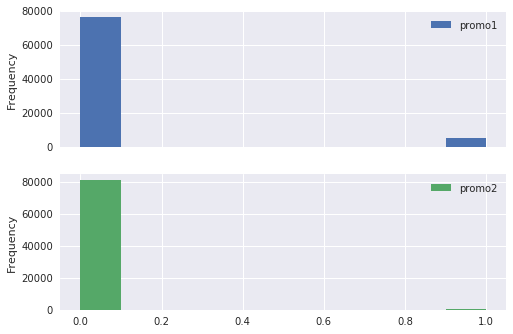

In [28]:
plt.figure()
data_joined.plot(y = ['promo1', 'promo2'], kind = 'hist', subplots = True)
plt.show()

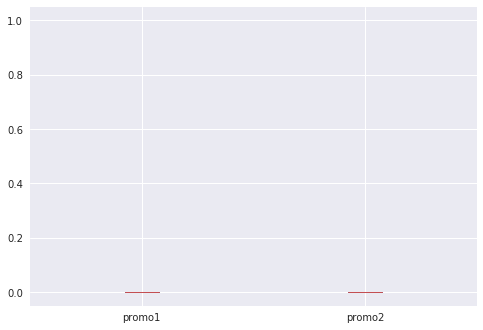

In [29]:
plt.figure()
data_joined.plot(y = ['promo1', 'promo2'], kind = 'box')
plt.show()

Plotting the promotion data doesn't yield much when looking for a distribution since the values are either '0' or '1' at all times. It is good to confirm that the data is clean.

Inspect the actual cost data from the second text data file holding attribute data for each article of clothing.

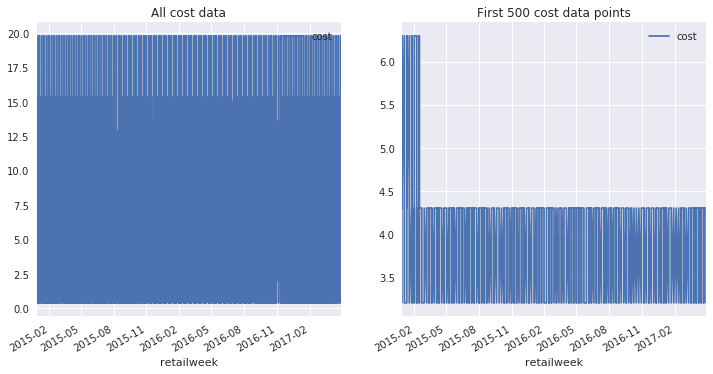

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], x = 'retailweek', y = 'cost')
axes[0].set_title('All cost data')
data_joined[0:500].plot(ax = axes[1], x = 'retailweek', y = 'cost')
axes[1].set_title('First 500 cost data points')
plt.show()

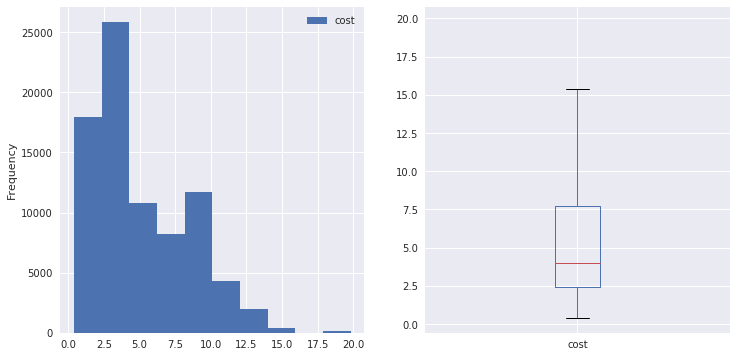

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12,6))
data_joined.plot(ax = axes[0], y = 'cost', kind = 'hist')
data_joined.plot(ax = axes[1], y = 'cost', kind = 'box')
plt.show()

Cost data looks reasonable; there aren't any large outliers. There is one item that costs roughly 20 euro. The data is skewed similarly to the other numerical data, although the shape is closest to the price data. I'll examine the potential outlier to see if it seems like a real data point.


In [32]:
data_joined[data_joined['cost'] > 17].shape


(123, 12)

In [33]:
data_joined[data_joined['cost'] > 17]

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,category,productgroup,cost
37761,Germany,NE7168,31,197.95,73.95,0.373579,2014-12-28,1,0,PORSCHE,SHOES,19.8
37762,Germany,NE7168,22,197.95,125.95,0.636272,2015-01-04,0,0,PORSCHE,SHOES,19.8
37763,Germany,NE7168,12,197.95,145.95,0.737307,2015-01-11,0,0,PORSCHE,SHOES,19.8
37764,Germany,NE7168,3,197.95,157.95,0.797929,2015-01-18,0,0,PORSCHE,SHOES,19.8
37765,Germany,NE7168,28,197.95,130.95,0.661531,2015-01-25,0,0,PORSCHE,SHOES,19.8
37766,Germany,NE7168,13,197.95,141.95,0.717100,2015-02-01,0,0,PORSCHE,SHOES,19.8
37767,Germany,NE7168,7,197.95,192.95,0.974741,2015-02-08,0,0,PORSCHE,SHOES,19.8
37768,Germany,NE7168,60,197.95,136.95,0.691841,2015-02-15,0,0,PORSCHE,SHOES,19.8
37769,Germany,NE7168,51,197.95,117.95,0.595858,2015-02-22,0,0,PORSCHE,SHOES,19.8
37770,Germany,NE7168,22,197.95,132.95,0.671634,2015-03-01,0,0,PORSCHE,SHOES,19.8


The data point above is a real data point. There are 123 transactional sales data points for the Porsche shoes. I know that adidas has a relationship with Porsche for branding of clothing and it would make sense for it to be more expensive that a non-Porsche branded piece of clothing considering the Porsche brand.
Overall, the data looks great. I'll move on to digging into the data to find what drives sales and if the promotions provide value add to sales numbers while keeping profits high.